# Parametric UMAP vs Align UMAP

In [1]:
from collections import OrderedDict
import itertools
from pathlib import Path
import pickle
import re

from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
import tqdm

from umap.aligned_umap import AlignedUMAP
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

from biovectors_modules.word2vec_analysis_helper import window

# Parametric UMAP

## Unaligned Models

In [2]:
unaligned_word_models = list(
    Path("../multi_model_experiment/output/models").rglob("*model")
)
unaligned_word_models = sorted(unaligned_word_models, key=lambda x: x.stem)
unaligned_word_model_filter = list(
    filter(lambda x: "_0" in x.stem, unaligned_word_models)
)

In [3]:
word_freq_count_cutoff = 5
odd_year_subset = unaligned_word_model_filter[15:-1:2]

In [4]:
training_unaligned_word_model_map = dict()
for word_file in tqdm.tqdm(odd_year_subset):
    model = Word2Vec.load(str(word_file)).wv
    training_unaligned_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.get_vecattr(x[1], "count") > word_freq_count_cutoff
                else x[0],
                enumerate(model.index_to_key),
            )
        ),
    )

100%|██████████| 3/3 [01:23<00:00, 27.75s/it]


In [5]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [6]:
for year in tqdm.tqdm(training_unaligned_word_model_map):
    model = training_unaligned_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.index_to_key[: training_unaligned_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.index_to_key[
                : training_unaligned_word_model_map[year]["cutoff_index"]
            ],
        )
    )
    year_labels_list += [year] * len(
        model.index_to_key[: training_unaligned_word_model_map[year]["cutoff_index"]]
    )

 33%|███▎      | 1/3 [00:00<00:00,  2.27it/s]

('2015', (147527, 300))


 67%|██████▋   | 2/3 [00:00<00:00,  2.17it/s]

('2017', (169505, 300))


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

('2019', (186185, 300))


In [7]:
training_unaligned_words = np.vstack(words_to_visualize)
training_unaligned_words.shape

(503217, 300)

In [8]:
umap_model_path = Path("output/unaligned_parametric_umap_model")
if not umap_model_path.exists():
    unaligned_parametric_model = ParametricUMAP(
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.99,
        n_training_epochs=1,
    )
    umap_embeddings = unaligned_parametric_model.fit_transform(training_unaligned_words)
    unaligned_parametric_model.save(str(umap_model_path))
else:
    unaligned_parametric_model = load_ParametricUMAP(umap_model_path)
    umap_embeddings = unaligned_parametric_model.transform(training_unaligned_words)

Mon Feb  7 00:17:56 2022 Building and compiling search function
Pickle of ParametricUMAP model loaded from output/unaligned_parametric_umap_model/model.pkl
Keras encoder model loaded from output/unaligned_parametric_umap_model/encoder
Keras full model loaded from output/unaligned_parametric_umap_model/parametric_model
504/504 [==============================] - 1s 1ms/step


In [9]:
train_plot_df = (
    pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
    >> ply.define(year=year_labels_list, tok=token_character_list)
    >> ply.call(".dropna")
    >> ply.define(umap1="umap1.astype(float)")
)
train_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,-1.772979,3.380629,2015,\
1,-1.321212,-0.058365,2015,the
2,-1.414979,0.874305,2015,","
3,-1.892773,0.889378,2015,\.
4,-1.481261,1.721570,2015,of
5,-2.023406,0.385968,2015,and
6,-2.184610,1.722276,2015,in
7,-1.382699,1.130644,2015,\-
8,-1.999938,-1.112695,2015,to
9,2.753628,4.642680,2015,\)


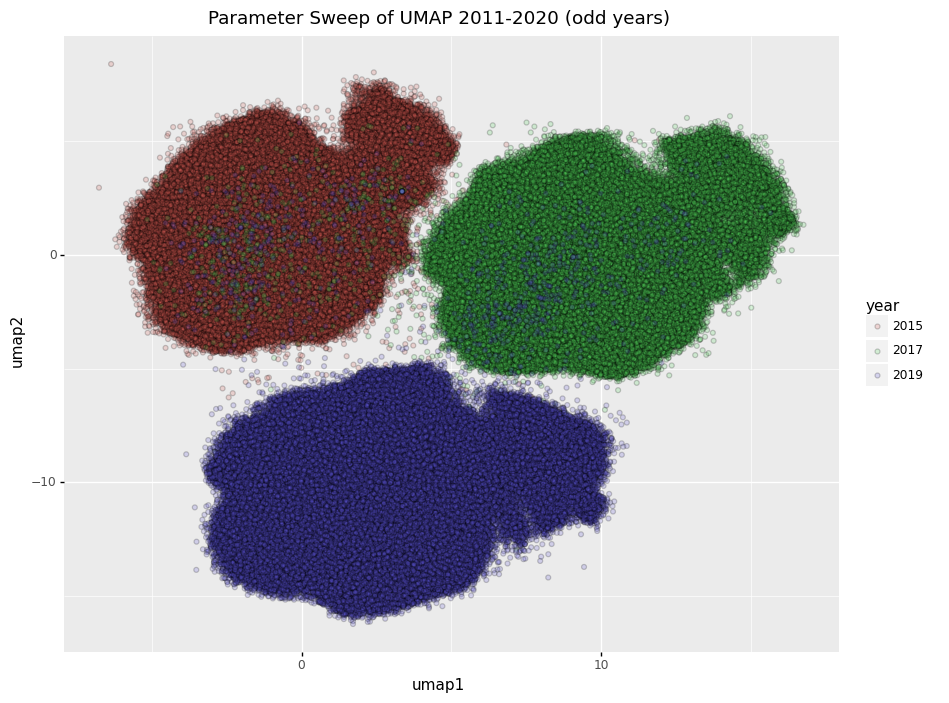

In [10]:
g = (
    p9.ggplot(
        train_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.labs(title="Parameter Sweep of UMAP 2011-2020 (odd years)")
    + p9.theme(figure_size=(10, 8))
)
print(g)

## Project held out data onto the training years

In [11]:
validation_word_model_map = dict()
for word_file in tqdm.tqdm(unaligned_word_model_filter[10:15]):
    model = Word2Vec.load(str(word_file)).wv
    validation_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.get_vecattr(x[1], "count") > word_freq_count_cutoff
                else x[0],
                enumerate(model.index_to_key),
            )
        ),
    )

100%|██████████| 5/5 [01:20<00:00, 16.11s/it]


In [12]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [13]:
for year in tqdm.tqdm(validation_word_model_map):
    model = validation_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.index_to_key[: validation_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.index_to_key[: validation_word_model_map[year]["cutoff_index"]],
        )
    )
    year_labels_list += [year] * len(
        model.index_to_key[: validation_word_model_map[year]["cutoff_index"]]
    )

 20%|██        | 1/5 [00:00<00:01,  3.79it/s]

('2010', (85285, 300))


 40%|████      | 2/5 [00:00<00:00,  3.65it/s]

('2011', (96901, 300))


 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

('2012', (106998, 300))


 80%|████████  | 4/5 [00:01<00:00,  3.19it/s]

('2013', (119889, 300))


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

('2014', (135842, 300))


In [14]:
umap_embeddings = unaligned_parametric_model.transform(np.vstack(words_to_visualize))

545/545 [==============================] - 1s 1ms/step


In [15]:
val_plot_df = (
    pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
    >> ply.define(year=year_labels_list, tok=token_character_list)
    >> ply.call(".dropna")
    >> ply.define(umap1="umap1.astype(float)")
)
val_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,-0.743397,-11.469948,2010,\
1,8.138481,-0.736208,2010,the
2,-2.060732,-0.636128,2010,of
3,7.958380,-1.809183,2010,","
4,6.756214,-2.568632,2010,\.
5,-0.426220,-12.288489,2010,and
6,7.402213,-1.656024,2010,in
7,0.852333,-10.275620,2010,\-
8,-0.317728,-11.349041,2010,to
9,-0.110788,-11.708324,2010,a


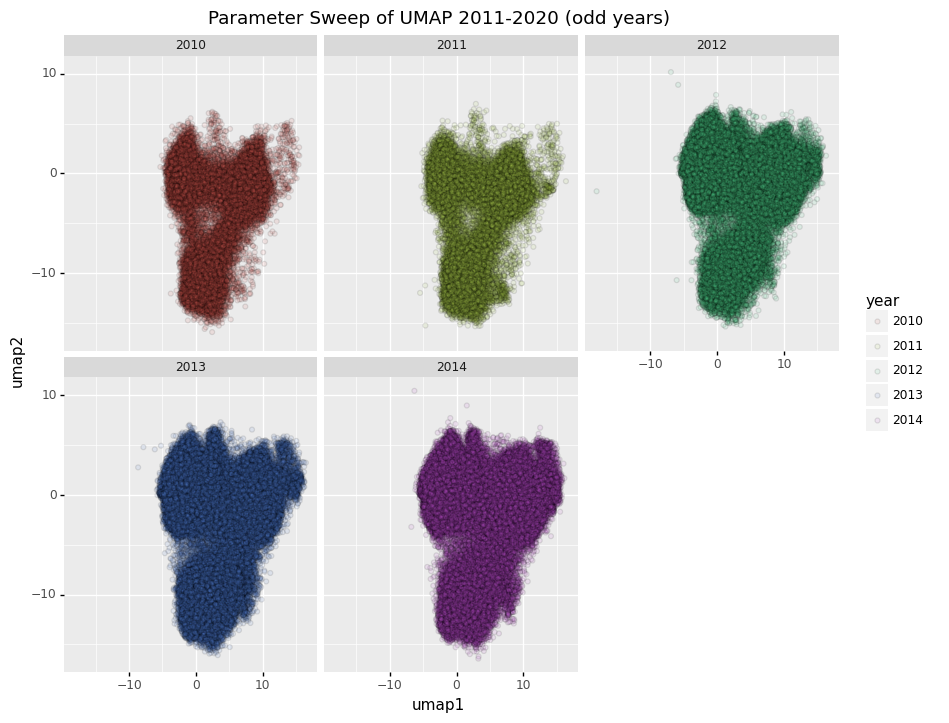

In [16]:
g = (
    p9.ggplot(
        val_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.1)
    + p9.labs(title="Parameter Sweep of UMAP 2011-2020 (odd years)")
    + p9.theme(figure_size=(10, 8))
    + p9.facet_wrap("year")
)
print(g)

## Aligned Models

In [17]:
aligned_word_models = list(
    Path("../multi_model_experiment/output/aligned_vectors_tmp").rglob("*kv")
)
aligned_word_models = sorted(aligned_word_models, key=lambda x: x.stem)
aligned_word_model_filter = list(filter(lambda x: "_0" in x.stem, aligned_word_models))

In [18]:
word_freq_count_cutoff = 1
odd_year_subset = aligned_word_model_filter[17:-1:2]

In [19]:
aligned_training_word_model_map = dict()
for word_file in tqdm.tqdm(odd_year_subset):
    model = KeyedVectors.load(str(word_file))
    aligned_training_word_model_map[word_file.stem.split("_")[0]] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.get_vecattr(x[1], "count") > word_freq_count_cutoff
                else x[0],
                enumerate(model.index_to_key),
            )
        ),
    )

100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


In [20]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [21]:
for year in tqdm.tqdm(aligned_training_word_model_map):
    model = aligned_training_word_model_map[year]["model"]
    word_subset_matrix = model[model.index_to_key]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(map(lambda x: re.escape(x), model.index_to_key))
    year_labels_list += [year] * len(model.index_to_key)

 50%|█████     | 1/2 [00:00<00:00,  1.41it/s]

('2017', (264969, 300))
('2019', (285138, 300))


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


In [22]:
aligned_training_words = np.vstack(words_to_visualize)
aligned_training_words.shape

(550107, 300)

In [23]:
umap_model_path = Path("output/aligned_parametric_umap_model")
if not umap_model_path.exists():
    aligned_parametric_model = ParametricUMAP(
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=20,
        min_dist=0.99,
        n_training_epochs=1,
    )
    umap_embeddings = aligned_parametric_model.fit_transform(aligned_training_words)
    aligned_parametric_model.save(str(umap_model_path))
else:
    aligned_parametric_model = load_ParametricUMAP(umap_model_path)
    umap_embeddings = aligned_parametric_model.transform(aligned_training_words)

Mon Feb  7 00:20:32 2022 Building and compiling search function
Pickle of ParametricUMAP model loaded from output/aligned_parametric_umap_model/model.pkl
Keras encoder model loaded from output/aligned_parametric_umap_model/encoder
Keras full model loaded from output/aligned_parametric_umap_model/parametric_model
551/551 [==============================] - 1s 1ms/step


In [24]:
aligned_train_plot_df = (
    pd.DataFrame(umap_embeddings, columns=["umap1", "umap2"])
    >> ply.define(year=year_labels_list, tok=token_character_list)
    >> ply.call(".dropna")
    >> ply.define(umap1="umap1.astype(float)")
)
aligned_train_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,0.521893,-1.006331,2017,\
1,-2.632137,1.573548,2017,the
2,-0.829617,0.295718,2017,","
3,-1.582589,0.676961,2017,\.
4,-1.008535,0.872306,2017,of
5,-1.065159,0.689112,2017,and
6,-0.941818,1.156830,2017,in
7,-1.412632,0.398565,2017,\-
8,-3.208784,2.074306,2017,to
9,6.242187,-4.819257,2017,\)


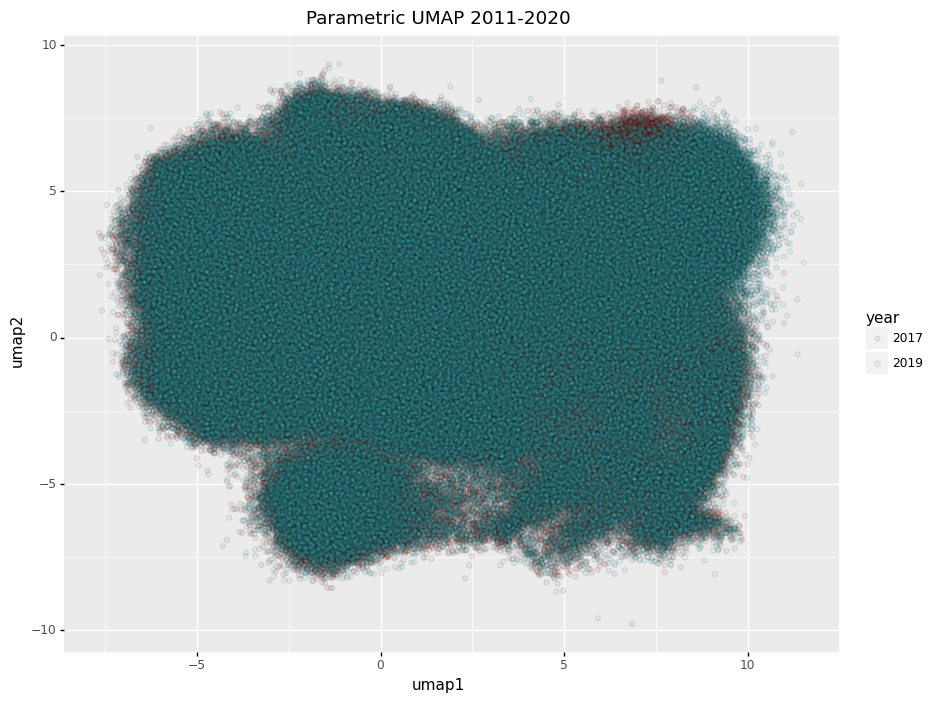

In [25]:
g = (
    p9.ggplot(
        aligned_train_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.1)
    + p9.labs(title="Parametric UMAP 2011-2020")
    + p9.theme(figure_size=(10, 8))
)
print(g)

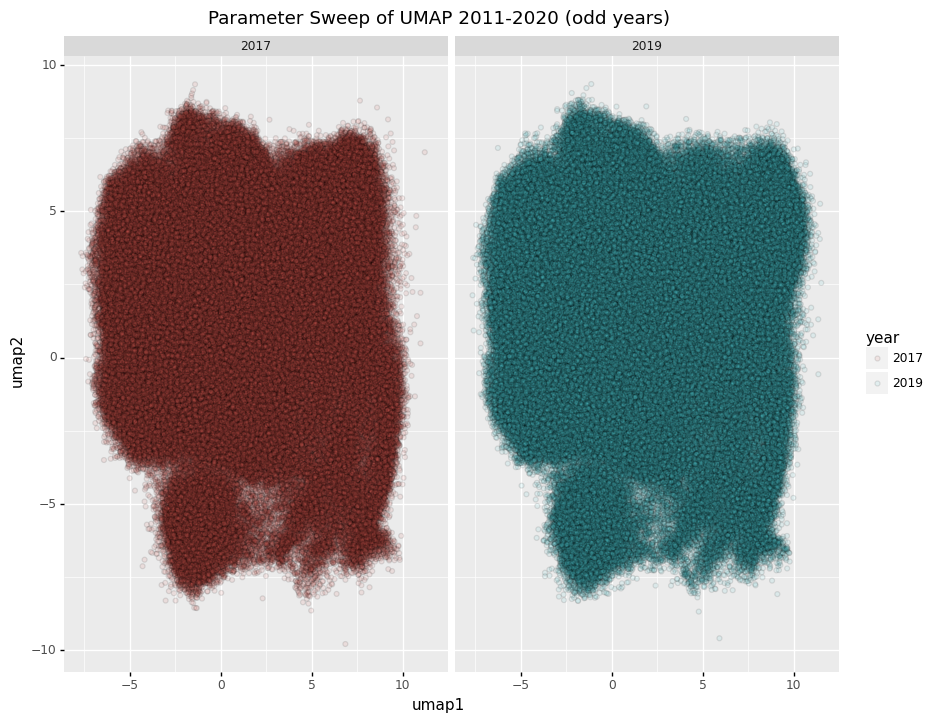

In [26]:
g = (
    p9.ggplot(
        aligned_train_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.1)
    + p9.labs(title="Parameter Sweep of UMAP 2011-2020 (odd years)")
    + p9.theme(figure_size=(10, 8))
    + p9.facet_wrap("year")
)
print(g)

# Aligned UMAP

In [27]:
word_freq_count_cutoff = 5
training_word_model_map = OrderedDict()

In [28]:
for word_file in tqdm.tqdm(unaligned_word_model_filter[10:]):
    model = Word2Vec.load(str(word_file)).wv
    year = word_file.stem.split("_")[0]

    training_word_model_map[year] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.get_vecattr(x[1], "count") > word_freq_count_cutoff
                else x[0],
                enumerate(model.index_to_key),
            )
        ),
    )

    training_word_model_map[year]["index_to_token_map"] = dict(
        zip(
            model.index_to_key[: training_word_model_map[year]["cutoff_index"]],
            range(
                len(model.index_to_key[: training_word_model_map[year]["cutoff_index"]])
            ),
        )
    )

100%|██████████| 11/11 [02:57<00:00, 16.14s/it]


In [29]:
relations = []
for year_one, year_two in tqdm.tqdm(window(training_word_model_map, 2)):
    year_one_map = training_word_model_map[year_one]["index_to_token_map"]
    year_two_map = training_word_model_map[year_two]["index_to_token_map"]
    relations.append(
        {
            year_one_map[tok]: year_two_map[tok]
            for tok in year_one_map
            if tok in year_two_map
        }
    )

10it [00:00, 15.88it/s]


In [30]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [31]:
for year in tqdm.tqdm(training_word_model_map):
    model = training_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.index_to_key[: training_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.index_to_key[: training_word_model_map[year]["cutoff_index"]],
        )
    )
    year_labels_list += [year] * len(
        model.index_to_key[: training_word_model_map[year]["cutoff_index"]]
    )

  9%|▉         | 1/11 [00:00<00:02,  3.89it/s]

('2010', (85285, 300))


 18%|█▊        | 2/11 [00:00<00:02,  3.73it/s]

('2011', (96901, 300))


 27%|██▋       | 3/11 [00:00<00:02,  3.50it/s]

('2012', (106998, 300))


 36%|███▋      | 4/11 [00:01<00:02,  3.22it/s]

('2013', (119889, 300))


 45%|████▌     | 5/11 [00:01<00:02,  2.92it/s]

('2014', (135842, 300))


 55%|█████▍    | 6/11 [00:02<00:01,  2.65it/s]

('2015', (147527, 300))


 64%|██████▎   | 7/11 [00:02<00:01,  2.45it/s]

('2016', (157142, 300))


 73%|███████▎  | 8/11 [00:03<00:01,  2.26it/s]

('2017', (169505, 300))


 82%|████████▏ | 9/11 [00:03<00:00,  2.11it/s]

('2018', (176358, 300))


 91%|█████████ | 10/11 [00:04<00:00,  1.99it/s]

('2019', (186185, 300))


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

('2020', (136410, 300))


In [32]:
aligned_umap_output_path = Path("output/aligned_umap_model.pkl")
if not aligned_umap_output_path.exists():
    # runtime - 3h 44m 17s
    aligned_umap_model = AlignedUMAP(
        n_components=2,
        verbose=True,
        metric="cosine",
        random_state=101,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.99,
        alignment_window_size=2,
        alignment_regularisation=1e-3,
    )
    aligned_umap_model.fit(words_to_visualize, relations=relations)
    aligned_umap_model.embeddings_ = list(aligned_umap_model.embeddings_)
    pickle.dump(aligned_umap_model, open(str(aligned_umap_output_path), "wb"))
else:
    aligned_umap_model = pickle.load(open(str(aligned_umap_output_path), "rb"))

Mon Feb  7 00:24:24 2022 Building and compiling search function
Mon Feb  7 00:24:28 2022 Building and compiling search function
Mon Feb  7 00:24:33 2022 Building and compiling search function
Mon Feb  7 00:24:38 2022 Building and compiling search function
Mon Feb  7 00:24:44 2022 Building and compiling search function
Mon Feb  7 00:24:51 2022 Building and compiling search function
Mon Feb  7 00:24:57 2022 Building and compiling search function
Mon Feb  7 00:25:04 2022 Building and compiling search function
Mon Feb  7 00:25:11 2022 Building and compiling search function
Mon Feb  7 00:25:19 2022 Building and compiling search function
Mon Feb  7 00:25:25 2022 Building and compiling search function


In [33]:
aligned_plot_df = pd.DataFrame(
    np.vstack(aligned_umap_model.embeddings_), columns=["umap1", "umap2"]
) >> ply.define(year="year_labels_list", tok="token_character_list")
aligned_plot_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,-0.063144,-4.804184,2010,\
1,1.907398,1.905113,2010,the
2,1.925217,2.093864,2010,of
3,2.056771,2.190396,2010,","
4,2.043776,2.331739,2010,\.
5,2.112347,2.361096,2010,and
6,2.011112,1.931211,2010,in
7,3.102991,-2.526640,2010,\-
8,1.591898,2.442492,2010,to
9,1.980048,1.707056,2010,a


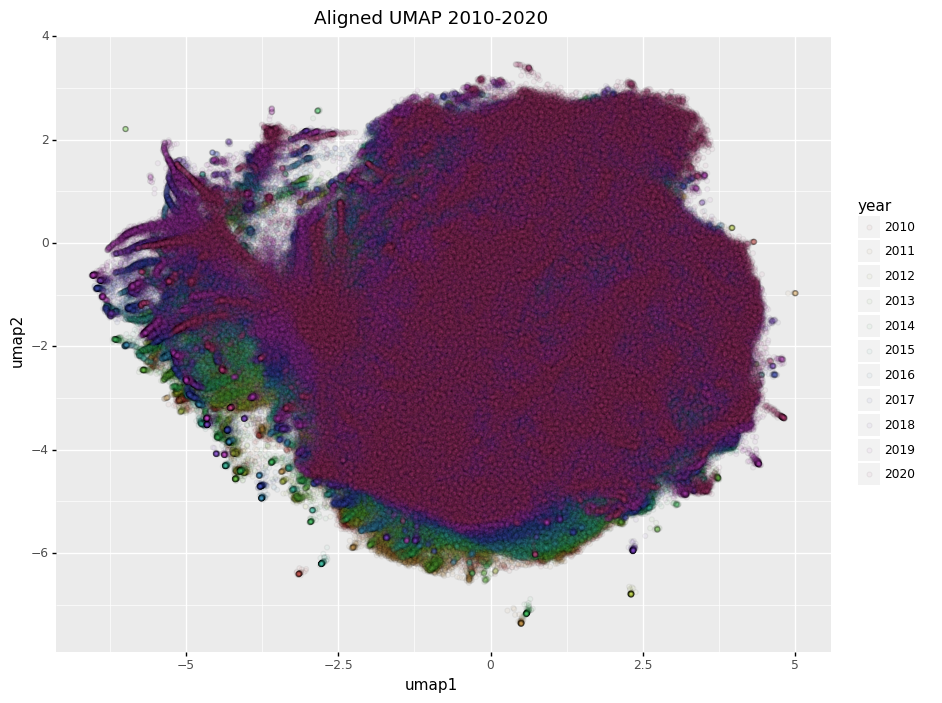

In [34]:
g = (
    p9.ggplot(
        aligned_plot_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.05)
    + p9.labs(title="Aligned UMAP 2010-2020")
    + p9.theme(figure_size=(10, 8))
)
print(g)